# Assignment 2 for COMP7105

### Lian Huan, 30305915175

Some thing I need to mention here. The results you see below, mainly about the calculation speed, is hard to be reproduced. I ran my python on Inter I7 core. I used numba to speed-up only the Euclidean and Pivot function, and some effects of the speed-up still took effect after I re-ran the codes without using numba, since it is hard for me to deal with the compatability between different modules like time module. Another, like I said in my e-mail, I'm not familiar with python, so my progamming skill might limit the speed of the whole function.

Thanks for your understanding!

## Step 1 Data loading and computation of pivots

### Step 1.1 Modules and data

In [1]:
import numpy as np
import pandas as pd
import time
import heapq
import matplotlib.pyplot as plt
#from numba import jit

In [2]:
data0 = pd.read_csv("data10K10.txt",sep=' ',header = None)
data0 = data0.drop(columns = 10)
data0.head()  # One more column
# That's the data.

,0,1,2,3,4,5,6,7,8,9
0,0.969,0.200,0.788,0.946,0.219,0.323,0.454,0.970,0.339,0.171
1,0.017,0.552,0.138,0.077,0.569,0.479,0.766,0.171,0.615,0.929
2,0.150,0.927,0.044,0.961,0.128,0.354,0.242,0.713,0.579,0.437
3,0.552,0.169,0.967,0.409,0.140,0.693,0.329,0.589,0.038,0.635
4,0.560,0.931,0.677,0.585,0.160,0.317,0.798,0.619,0.394,0.836


In [3]:
data1 = pd.read_csv("queries10.txt",sep=' ',header = None)
data1 = data1.drop(columns = 10)
data1.head()  # One more column
# That's the queries.

,0,1,2,3,4,5,6,7,8,9
0,0.419,0.744,0.934,0.751,0.238,0.610,0.523,0.785,0.586,0.347
1,0.950,0.589,0.024,0.872,0.221,0.688,0.089,0.275,0.786,0.826
2,0.550,0.926,0.329,0.451,0.250,0.644,0.432,0.238,0.937,0.131
3,0.945,0.263,0.125,0.061,0.220,0.527,0.359,0.750,0.357,0.529
4,0.294,0.242,0.393,0.029,0.990,0.468,0.598,0.857,0.152,0.891


### Step 1.2 Pivot function
Setting up the global variables is only deal with possible other un-scaled data.  
It is important to transfer `pd.dataframe` to `list`, or the calculation will be much slower.I've provided alter result for you.  
In addition, I used some methods to speed up the `for`, and used less `Euclidean` for calculation in this step. The number of distance calculation is (num_pivots+1)\*num_rows

In [4]:
# Global variables
max_data = data0.max()
min_data = data0.min()
num_row = data0.shape[0]
num_col = data0.shape[1]
max_min= max_data - min_data
data0_pd = data0 # pd.dataframme format
data1_pd = data1 # pd.dataframme format

In [5]:
# Important to use this step.I've provided alter result for you.
data0 = data0.values.tolist()
data1 = data1.values.tolist()
max_data = max_data.to_numpy()
min_data = min_data.to_numpy()
max_min = max_min.to_numpy()

In [6]:
# Euclidean distance
#@jit(nopython=True)
def Euclidean(x,y): 
    distance = 0
    for i in range(0,10):
        if x[i] != -1 and y[i] != -1:            
            aa = (x[i]-min_data[i])/max_min[i]
            bb = (y[i]-min_data[i])/max_min[i]
        else:
            aa = 0
            bb = 0
        distance = distance + (aa-bb)**2
    distance = pow(distance,0.5)
    return(distance)

#Pivots calculation
#@jit(nopython=True)
def Pivots(x,num_pivots):
    start = time.time()
    pivots = np.array([0])
    print("Using Pivots function! You want %u pivots." %(num_pivots))
    is_pddf = isinstance(x, pd.DataFrame)
    
    if is_pddf == True:
        print("Warning! A panda.dataframe is used, this will be slow.")
        # i  = 0, find the first pivot
        candidate_num = -1
        dist = -1
        for j in range(0,num_row):
            med_dist_sum = 0
            candidate_piv = x.iloc[j].values
            for k in pivots:
                previous_piv = x.iloc[k].values
                med_dist_sum = med_dist_sum + Euclidean(previous_piv,candidate_piv) 
            if med_dist_sum > dist:
                candidate_num = j
                dist = med_dist_sum
        pivots[0] = candidate_num
        med_matrix = np.zeros((num_row,num_pivots))
        
        # Find other pivots
        # i = 1 to i = 4 or i = 9
        for i in range(1,num_pivots):        
            candidate_num = -1
            dist = -1
            for j in range(0,num_row):
                med_dist_sum = 0
                candidate_piv = x.iloc[j].values
                for k in range(len(pivots)):
                    # med_matrix store all distances for each pivot to , but the last column
                    med_dist_sum = med_matrix[j,k] + med_dist_sum
                num = pivots[k]
                previous_piv = x.iloc[num].values
                eu_dis = Euclidean(previous_piv,candidate_piv)
                med_dist_sum = med_dist_sum + eu_dis
                # Comparing
                if med_dist_sum > dist:
                    candidate_num = j
                    dist = med_dist_sum
                med_matrix[j,i-1] = eu_dis
            pivots = np.append(pivots, candidate_num)
        
        # Add the last column
        pivots_output = pivots
        dis_matrix = med_matrix
        j0 = pivots_output[num_pivots-1]
        pivot_j = x.iloc[j0].values
        for i in range(0,num_row):
            obj_i = x.iloc[i].values
            distij = Euclidean(obj_i,pivot_j)
            dis_matrix[i,num_pivots-1] = distij
            
        #Summary
        end = time.time()
        output = {'vec' : pivots_output,'mat' : dis_matrix,'time': end - start}
        print('Pivot Function done in %.3f seconds! Maybe a bit slow.' %(end - start))
        return(output)
    else:
        print("You are using lists now, this will be faster.")
        
        # i  = 0
        candidate_num = -1
        dist = -1
        for j in range(0,num_row):
            med_dist_sum = 0
            candidate_piv = x[j]  # Main difference, .iloc is too slow!
            for k in pivots:
                previous_piv = x[k]
                med_dist_sum = med_dist_sum + Euclidean(previous_piv,candidate_piv) 
            if med_dist_sum > dist:
                candidate_num = j
                dist = med_dist_sum
        pivots[0] = candidate_num
        #print(counter)
        med_matrix = np.zeros((num_row,num_pivots))
        
        # i = 1 to i = 4 or i = 9
        for i in range(1,num_pivots):        
            candidate_num = -1
            dist = -1
            for j in range(0,num_row):
                med_dist_sum = 0
                candidate_piv = x[j]
                for k in range(len(pivots)):
                    med_dist_sum = med_matrix[j,k] + med_dist_sum
                num = pivots[k]
                previous_piv = x[num]
                eu_dis = Euclidean(previous_piv,candidate_piv)
                med_dist_sum = med_dist_sum + eu_dis
                # Comparing
                if med_dist_sum > dist:
                    candidate_num = j
                    dist = med_dist_sum
                med_matrix[j,i-1] = eu_dis
            #print(counter)
            pivots = np.append(pivots, candidate_num)
            
        pivots_output = pivots
        dis_matrix = med_matrix
        j0 = pivots_output[num_pivots-1]
        pivot_j = x[j0]
        for i in range(0,num_row):
            obj_i = x[i]
            distij = Euclidean(obj_i,pivot_j)
            dis_matrix[i,num_pivots-1] = distij
            
        end = time.time()
        output = {'vec' : pivots_output,'mat' : dis_matrix,'time': end - start}
        print('Pivot Function done in %.3f seconds.' %(end - start))
        return(output)
    
num_pivots = 10
output_pd = Pivots(data0_pd,num_pivots)
output = Pivots(data0,num_pivots)

Using Pivots function! You want 10 pivots.
Warning! A panda.dataframe is used, this will be slow.
Pivot Function done in 7.909 seconds! Maybe a bit slow.
Using Pivots function! You want 10 pivots.
You are using lists now, this will be faster.
Pivot Function done in 1.009 seconds.


In [7]:
print(output['vec'])
#print(output['mat'])

[1109 6878 5514 5026 5338  714 5825 7016 5062 2355]


### A summary

Pivot funciton will return a dictionary  `{'vec' : which are pivots, 'mat' : distance matrix, 'time' : timer.}`

 5 pivots: [1109, 6878, 5514, 5026, 5338]  
10 pivots:[1109, 6878, 5514, 5026, 5338,  714, 5825, 7016, 5062, 2355]  

This is the timer's result.    
Using Pivots function! You want 10 pivots.  
Warning! A panda.dataframe is used, this will be slow.  
Pivot Function done in 7.909 seconds! Maybe a bit slow.  
Using Pivots function! You want 10 pivots.  
You are using lists now, this will be faster.  
Pivot Function done in 1.009 seconds.  

## Step 2 iDistance method

In [8]:
#iDistance Calculation
def iDistance(x, input):
    start = time.time()
    print("Using iDistance Funciton now!")    
    num_pivots = len(input['vec'])
    maxd_p = []
    
    # Calculate max_di and max_d
    for j in range(0,num_pivots):
        maxd_p.append(input['mat'][:,j].max())
    maxd = max(maxd_p)
    
    # Calculate iDistances
    idis_array = []
    for i in range(0,num_row):
        npiv_o = np.argmin(input['mat'][i,:])  # find which p_i it is 
        iDist = npiv_o*maxd+input['mat'][i,npiv_o]
        idis_array.append([iDist,i,npiv_o])
    idis_array.sort(key= lambda x:(x[0],x[2]))    
    output = {'idis':idis_array,'maxd':maxd,'maxdi':maxd_p}    
    end = time.time()
    print('iDistance Function done in %.4f seconds.' %(end - start))
    return(output)
    
iDist = iDistance(data0,output) 
Pivots0 = output
   

Using iDistance Funciton now!
iDistance Function done in 0.0450 seconds.


### A summary

iDistance function will return a dicitonary `{'idis' : idistance array [iDistance, number of row in data, which is the closet pivot] , 'maxd': max distance,'maxdi':max distance for each pivot} `

This is the timer's result.   
Using iDistance Funciton now.  
iDistance Function done in 0.0450 seconds.

## Step 3: Range similarity queries

In [9]:
# Note that the iDist and Pivots have been provided.
# From now there will be no pandas.dataframe api provided.
# Global options
num_row = np.array(data0).shape[0]
num_col = np.array(data0).shape[1]
num_row_q = np.array(data1).shape[0]
num_col_q = np.array(data1).shape[1]
if num_col != num_col_q:
    print("Warning!Inconsistent dimensions")

#Binary Search
def BinarySearch(arr,key):
    l,r=0,len(arr)-1
    if arr[l]>key:
        return l
    if arr[r]<=key:
        return 9999
    while(l+1<r):
        m=(l+r)//2
        if(arr[m]<key):
            l=m
        else:
            r=m
    return(r)
 
#naive function
def naive(x,y_oneline,epsi,method):
    num_row0 = len(x)
    output_query = []
    count0 = 0
    # For step 3
    if method == 'Search':
        for i in range(num_row0):
            dist = Euclidean(x[i],y_oneline)
            count0 = count0 + 1 
            if dist <= epsi:
                output_query.append(i)
        return output_query, count0 
    #For step 4
    elif method == 'kNN':
        for i in range(num_row0):
            dist = Euclidean(x[i],y_oneline)
            count0 = count0 + 1
            heapq.heappush(output_query,[-dist,i])
        output0 = heapq.nlargest(epsi, output_query)
        return output0, count0
    else:
        print("Warning in naive function!")
        return(0)
    
#Pivots and iDist is needed!
# x = data, y = query, methods, epsilon, number of pivots, whether you want a quick summary output.
def simi_search(x,y,method,epsi,num_pivots,option):
    start = time.time()
    if option == True:
        print("Using %s Search Funciton now!" %(method))
    # naive
    if method == "naive" :
        output_list = list()
        counter = 0
        for i in y:
            output_query, count_sub = naive(x,i,epsi,"Search")
            counter = counter + count_sub
            output_list.append(output_query)
        #summary
        avg_counter = counter/num_row_q
        end = time.time()
        if option == True:
            print('Search %s function done in %.3f seconds.' %(method, end - start))
            print('Average time for each query is %.5f seconds.'%((end-start)/num_row_q))
            print('Total calculation is %.1f ! Average calculation for each query is %.1f .'%(counter, avg_counter))
        output = {'time':end-start,'method':method ,'count':avg_counter,'list_of_output':output_list}
        return(output)
    # pivots
    elif method == "pivots":
        counter = 0
        output_list = list()
        for i in range(num_row_q):
            med_dist = []
            output_query = []
            
            # find distance pivot to query
            for j in range(num_pivots):
                pi = Pivots0['vec'][j]
                pi_obj = x[pi]
                dist_pq = Euclidean(x[pi],y[i])
                counter = counter+1
                med_dist.append(dist_pq)
                
            # pruning and forming the result.
            for i1 in range(0,num_row):
                dist = 1
                abs_dist = 0
                exit_flag = False
                for j1 in range(0,num_pivots):
                    abs_dist = abs(med_dist[j1] - Pivots0['mat'][i1,j1])
                    if abs_dist > epsi:
                        exit_flag = True
                        break
                if exit_flag == False:
                    dist = Euclidean(y[i],x[i1])
                    counter = counter+1
                    if dist <= epsi:
                        output_query.append(i1)
            output_list.append(output_query)
        # summary
        avg_counter = counter/num_row_q
        end = time.time()
        if option == True:
            print('Search %s function done in %.3f seconds.' %(method, end - start))
            print('Average time for each query is %.5f seconds.'%((end-start)/num_row_q))
            print('Total calculation is %.1f ! Average calculation for each query is %.2f .'%(counter, avg_counter))
        output = {'time':end-start,'method':method ,'count':avg_counter,'list_of_output':output_list}
        return(output)
    # iDistance
    elif method == "iDistance":
        counter = 0
        output_list = list()
        iDist_idis = np.array(iDist['idis'])
        iDist_vec = iDist_idis[:,0]
        for i in range(0,num_row_q):
            output_query = []
            for j in range(0,num_pivots):
                pi = Pivots0['vec'][j]
                pi_obj = x[pi]
                dist_pq = Euclidean(x[pi],y[i])
                counter = counter+1
                minus_dist = dist_pq - iDist['maxdi'][j]
                # prune the pivot.
                if minus_dist <= epsi:
                    lower_bound = j*iDist['maxd'] + dist_pq - epsi
                    upper_bound = j*iDist['maxd'] + dist_pq + epsi
                    first_posi = BinarySearch(iDist_vec, lower_bound)
                    first_value = iDist['idis'][first_posi]
                    last_posi = BinarySearch(iDist_vec, upper_bound)
                    last_value = iDist['idis'][last_posi]
                    # Small modification, will be faster with smaller calculation
                    if last_value[0] != upper_bound and (last_posi-first_posi)>0 and last_posi != (num_row-1):
                        last_posi = last_posi - 1
                        last_value = iDist['idis'][last_posi]
                    # find the result
                    for k in range(first_posi,last_posi):
                        value = iDist['idis'][k]
                        # Avoid accessing objects which do not have pi as their nearest pivot.
                        if value[2] == j:
                            index = value[1]
                            dist = Euclidean(x[index],y[i])
                            counter = counter+1
                            if dist <= epsi:
                                output_query.append(index)
                        else:
                            continue
            output_list.append(output_query)
        #summary
        avg_counter = counter/num_row_q
        end = time.time()
        if option == True:
            print('Search %s function done in %.3f seconds.' %(method, end - start))
            print('Average time for each query is %.5f seconds.'%((end-start)/num_row_q))
            print('Total calculation is %.1f ! Average calculation for each query is %.2f .'%(counter, avg_counter))
        output = {'time':end-start,'method':method ,'count':avg_counter,'list_of_output':output_list}
        return(output)

In [10]:
Search_naive0 = simi_search(data0,data1,"naive",0.2,10,True)
Search_pivotsbased0 = simi_search(data0,data1,"pivots",0.2,10,True)
Search_iDistbased0 = simi_search(data0,data1,"iDistance",0.2,10,True)

Using naive Search Funciton now!
Search naive function done in 16.139 seconds.
Average time for each query is 0.08070 seconds.
Total calculation is 2000000.0 ! Average calculation for each query is 10000.0 .
Using pivots Search Funciton now!
Search pivots function done in 1.410 seconds.
Average time for each query is 0.00705 seconds.
Total calculation is 3342.0 ! Average calculation for each query is 16.71 .
Using iDistance Search Funciton now!
Search iDistance function done in 3.678 seconds.
Average time for each query is 0.01839 seconds.
Total calculation is 413307.0 ! Average calculation for each query is 2066.53 .


### A summary

The simi_search function will return a dictionary `{'time': timer , 'method': method , 'count': avg_counter, 'list_of_output' : result for each query}`  

This is the result ran on my machine, you can compare it if you will run my codes.  

Using naive Search Funciton now.  
Search naive function done in 16.139 seconds.  
Average time for each query is 0.08070 seconds.  
Total calculation is 2000000.0 ! Average calculation for each query is 10000.0 .  
Using pivots Search Funciton now.  
Search pivots function done in 1.410 seconds.  
Average time for each query is 0.00705 seconds.  
Total calculation is 3342.0 ! Average calculation for each query is 16.71 .  
Using iDistance Search Funciton now.  
Search iDistance function done in 3.678 seconds.  
Average time for each query is 0.01839 seconds.  
Total calculation is 413307.0 ! Average calculation for each query is 2066.53 .  

## Step 4: kNN similarity queries

In [11]:
#Pivots and iDist is needed!
# x = data, y = query, methods, number of pivots, k, whether you want a quick summary output.
# kNN_search
def kNN_search(x,y,method,num_pivots,k,option):
    start = time.time()
    if option == True:
        print("Using %s kNN Search Funciton now." %(method))
    # naive
    if method == "naive":
        output_list = list()
        counter = 0
        for i in y:
            output_query, count_sub = naive(x,i,k,"kNN")
            counter = counter + count_sub
            output_list.append(output_query)
        #summary
        avg_counter = counter/num_row_q
        end = time.time()
        if option == True:
            print('kNN Search %s function done in %.3f seconds.' %(method, end - start))
            print('Average time for each query is %.5f seconds.'%((end-start)/num_row_q))
            print('Total calculation is %.1f ! Average calculation for each query is %.1f .'%(counter, avg_counter))
        output = {'time':end-start,'method':method ,'count':avg_counter,'list_of_output':output_list}
        return(output)
    #pivots
    elif method == "pivots":
        counter = 0
        output_list = list()
        for i in range(num_row_q):
            # Calculate pivots - query dist.
            med_dist = []
            for j in range(num_pivots):
                pi = Pivots0['vec'][j]
                pi_obj = x[pi]
                dist_pq = Euclidean(x[pi],y[i])
                counter = counter+1
                med_dist.append(dist_pq)
            prior_queue = []  # initialize it     
            for i1 in range(0,num_row):
                dist = 0
                # first k.
                if len(prior_queue) < k:
                    dist = Euclidean(x[i1],y[i])
                    counter = counter+1
                    heapq.heappush(prior_queue, [-dist, i1])
                else:
                    #print(prior_queue)
                    epsi = -prior_queue[0][0]
                    exit_flag = False
                    # pruning and result
                    for j1 in range(0,num_pivots):
                        abs_dist = 0
                        abs_dist = abs(med_dist[j1] - Pivots0['mat'][i1,j1])
                        if abs_dist > epsi:
                            exit_flag = True
                            break
                    if exit_flag == False:
                        dist = Euclidean(y[i],x[i1])
                        counter = counter+1
                        if dist <= epsi:
                            useless = heapq.heapreplace(prior_queue, [-dist , i1])
            # Note that outputs are (-dist, i) !
            output_list.append(prior_queue)
        #summary
        avg_counter = counter/num_row_q
        end = time.time()
        if option == True:
            print('kNN Search %s function done in %.3f seconds.' %(method, end - start))
            print('Average time for each query is %.5f seconds.'%((end-start)/num_row_q))
            print('Total calculation is %.1f ! Average calculation for each query is %.2f .'%(counter, avg_counter))
        output = {'time':end-start,'method':method ,'count':avg_counter,'list_of_output':output_list}
        return(output)
    #iDistance
    elif method == "iDistance":
        counter = 0
        output_list = list()
        iDist_idis = np.array(iDist['idis'])
        iDist_vec = iDist_idis[:,0]
        for i in range(0,num_row_q):
            output_query = []
            med_dist = []
            # find the closed pivot
            for j in range(num_pivots):
                pi = Pivots0['vec'][j]
                pi_obj = x[pi]
                dist_pq = Euclidean(x[pi],y[i])
                counter = counter+1
                med_dist.append(dist_pq)
            min_pq = np.argmin(med_dist)

            # Range scan
            id_place = np.where(iDist['idis'] == min_pq)
            index_row_med = id_place[0][np.where(id_place[1] == 2)]
            index_row = np.array(iDist['idis'])[index_row_med.astype(int),1]
            data_set = np.array(x)[index_row.astype(int)]
            output_query, count_sub = naive(data_set,y[i],k,"kNN")
            heapq.heapify(output_query)
            counter = counter + count_sub
            epsi = -output_query[0][0]       
            
            # Modify to the original index
            for i0 in range(k):
                rownum_in_dataset = int(output_query[i0][1])
                rownum_in_iDist = int(index_row[rownum_in_dataset])
                output_query[i0][1] = rownum_in_iDist   
                
            # LB & UB
            for j0 in range(0,num_pivots):
                lower_bound = 0
                upper_bound = 0
                if min_pq == j0:
                    #Range scan all has been done!
                    continue
                else:
                    # Find the rows belongs to this index
                    # There will be a bit faster method, but more complicated.
                    #id_place = np.where(iDist['idis'] == j0)
                    #index_row = id_place[0][np.where(id_place[1] == 2)]
                    minus_dist = med_dist[j0] - iDist['maxdi'][j0]
                    # prune the pivots
                    if minus_dist <= epsi:
                        dist_pq_ = med_dist[j0]
                        lower_bound = j0*iDist['maxd'] + dist_pq_ - epsi
                        upper_bound = j0*iDist['maxd'] + dist_pq_ + epsi
                        first_posi = BinarySearch(iDist_vec, lower_bound)
                        first_value = iDist['idis'][first_posi]
                        last_posi = BinarySearch(iDist_vec, upper_bound)
                        last_value = iDist['idis'][last_posi]
                        # Small modification, but I will not use it in kNN, though it will reduce the computation cost.
                        #if last_value[0] != upper_bound and (last_posi-first_posi)>0 and last_posi != (num_row-1):
                        #    last_posi = last_posi - 1
                        #    last_value = iDist['idis'][last_posi]
                        # pruning, replacing and result.
                        for k0 in range(first_posi,last_posi):
                            value = iDist['idis'][k0]
                            if value[2] == j0:
                                index = value[1]
                                dist = Euclidean(x[index],y[i])
                                counter = counter+1
                                if dist <= epsi:
                                    heapq.heapreplace(output_query, [-dist , index])
                                    epsi = -output_query[0][0]
                            else:
                                continue
            output_list.append(output_query)
        #summary
        avg_counter = counter/num_row_q
        end = time.time()
        if option == True:
            print('kNN Search %s function done in %.3f seconds.' %(method, end - start))
            print('Average time for each query is %.5f seconds.'%((end-start)/num_row_q))
            print('Total calculation is %.1f ! Average calculation for each query is %.2f .'%(counter, avg_counter))
        output = {'time':end-start,'method':method ,'count':avg_counter,'list_of_output':output_list}
        return(output)

In [12]:
kNN_naive0 = kNN_search(data0,data1,"naive",10,5,True)
kNN_pivots0 = kNN_search(data0,data1,"pivots",10,5,True)
kNN_iDist0 = kNN_search(data0,data1,"iDistance",10,5,True)
#kNN_iDist0['list_of_output']
#kNN_pivots0['list_of_output']
#kNN_naive0['list_of_output']

Using naive kNN Search Funciton now.
kNN Search naive function done in 17.875 seconds.
Average time for each query is 0.08938 seconds.
Total calculation is 2000000.0 ! Average calculation for each query is 10000.0 .
Using pivots kNN Search Funciton now.
kNN Search pivots function done in 8.961 seconds.
Average time for each query is 0.04480 seconds.
Total calculation is 631352.0 ! Average calculation for each query is 3156.76 .
Using iDistance kNN Search Funciton now.
kNN Search iDistance function done in 14.531 seconds.
Average time for each query is 0.07266 seconds.
Total calculation is 1225430.0 ! Average calculation for each query is 6127.15 .


### A summary
The kNN_search function will return a dictionary `{'time': timer , 'method': method , 'count':avg_counter , 'list_of_output': result for each query}`
This is the result ran on my machine, you can compare it if you will run my codes.

Using naive kNN Search Funciton now.  
kNN Search naive function done in 17.875 seconds.  
Average time for each query is 0.08938 seconds.  
Total calculation is 2000000.0 ! Average calculation for each query is 10000.0 .  
Using pivots kNN Search Funciton now.  
kNN Search pivots function done in 8.961 seconds.  
Average time for each query is 0.04480 seconds.  
Total calculation is 631352.0 ! Average calculation for each query is 3156.76 .  
Using iDistance kNN Search Funciton now.  
kNN Search iDistance function done in 14.531 seconds.  
Average time for each query is 0.07266 seconds.  
Total calculation is 1225430.0 ! Average calculation for each query is 6127.15 .  

## Step 5: Evaluation

In this step, I used more values than required for each parameter. So the the resulting curve is also smoother, but will take more time. An alter array is provided for you if you want to run these codes, which will be slightly faster.

In [13]:
#epsi = 0.x
epsiset = np.arange(0.1,1,0.1)
#epsiset = [0.1,0.2,0.4,0.8]
result_time_simi = []
result_cal_simi = []
for epsi in epsiset:
    Search_naive1 = simi_search(data0,data1,"naive",epsi,10,False)
    Search_pivotsbased1 = simi_search(data0,data1,"pivots",epsi,10,False)
    Search_iDistbased1 = simi_search(data0,data1,"iDistance",epsi,10,False)
    result_time_simi.append([Search_naive1['time'],Search_pivotsbased1['time'],Search_iDistbased1['time']])
    result_cal_simi.append([Search_naive1['count'],Search_pivotsbased1['count'],Search_iDistbased1['count']])

In [14]:
# k = x
kset = np.array([1,5,10,25,40,50,60,75,90,100])
#kset = np.array([1,5,10,50,100])
result_time_kNN = []
result_cal_kNN = []
for k in kset:
    kNN_naive1 = kNN_search(data0,data1,"naive",10,k,False)
    kNN_pivots1 = kNN_search(data0,data1,"pivots",10,k,False)
    kNN_iDist1 = kNN_search(data0,data1,"iDistance",10,k,False)
    result_time_kNN.append([kNN_naive1['time'],kNN_pivots1['time'],kNN_iDist1['time']])
    result_cal_kNN.append([kNN_naive1['count'],kNN_pivots1['count'],kNN_iDist1['count']])

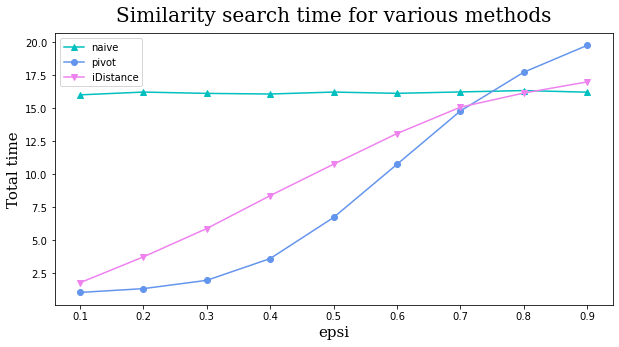

In [15]:
# Plot for simi search time.
plt.figure(figsize=(10, 5))
plt.plot(epsiset,np.array(result_time_simi)[:,0],'^-',color = 'c',label="naive")
plt.plot(epsiset,np.array(result_time_simi)[:,1],'o-',color = 'cornflowerblue',label="pivot")
plt.plot(epsiset,np.array(result_time_simi)[:,2],'v-',color = 'violet',label="iDistance")
plt.xlabel("epsi",fontsize = 15,family = 'serif')
plt.ylabel("Total time",fontsize = 15,family = 'serif')
plt.legend(loc = "best")
plt.title('Similarity search time for various methods',fontsize= 20,loc ='center',va = 'center',family = 'serif',y = 1.04) 
plt.show()

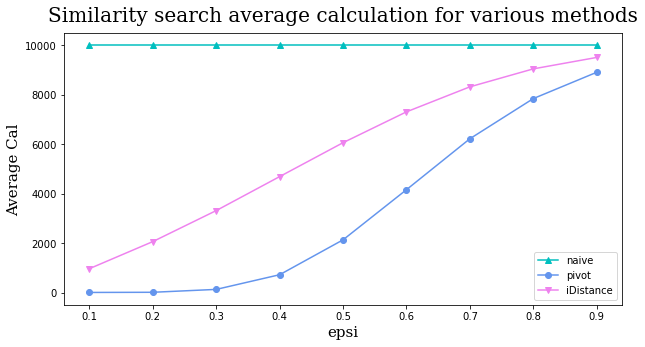

In [16]:
# Plot for simi search average calculation.
plt.figure(figsize=(10, 5))
plt.plot(epsiset,np.array(result_cal_simi)[:,0],'^-',color = 'c',label="naive")
plt.plot(epsiset,np.array(result_cal_simi)[:,1],'o-',color = 'cornflowerblue',label="pivot")
plt.plot(epsiset,np.array(result_cal_simi)[:,2],'v-',color = 'violet',label="iDistance")
plt.xlabel("epsi",fontsize = 15,family = 'serif')
plt.ylabel("Average Cal",fontsize = 15,family = 'serif')
plt.legend(loc = "best")
plt.title('Similarity search average calculation for various methods',fontsize= 20,loc ='center',va = 'center',family = 'serif',y = 1.04) 
plt.show()

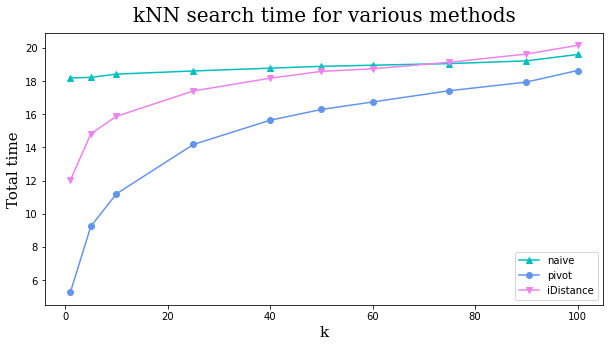

In [17]:
# Plot for kNN search time.
plt.figure(figsize=(10, 5))
plt.plot(kset,np.array(result_time_kNN)[:,0],'^-',color = 'c',label="naive")
plt.plot(kset,np.array(result_time_kNN)[:,1],'o-',color = 'cornflowerblue',label="pivot")
plt.plot(kset,np.array(result_time_kNN)[:,2],'v-',color = 'violet',label="iDistance")
plt.xlabel("k",fontsize = 15,family = 'serif')
plt.ylabel("Total time",fontsize = 15,family = 'serif')
plt.legend(loc = "best")
plt.title('kNN search time for various methods',fontsize= 20,loc ='center',va = 'center',family = 'serif',y = 1.04) 
plt.show()

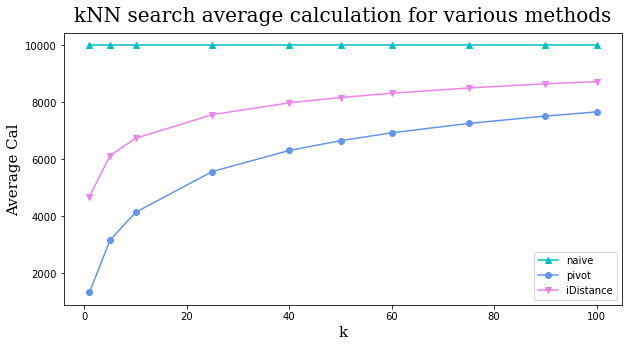

In [19]:
# Plot for kNN search average calculation.
plt.figure(figsize=(10, 5))
plt.plot(kset,np.array(result_cal_kNN)[:,0],'^-',color = 'c',label="naive")
plt.plot(kset,np.array(result_cal_kNN)[:,1],'o-',color = 'cornflowerblue',label="pivot")
plt.plot(kset,np.array(result_cal_kNN)[:,2],'v-',color = 'violet',label="iDistance")
plt.xlabel("k",fontsize = 15,family = 'serif')
plt.ylabel("Average Cal",fontsize = 15,family = 'serif')
plt.legend(loc = "best")
plt.title('kNN search average calculation for various methods',fontsize= 20,loc ='center',va = 'center',family = 'serif',y = 1.04) 
plt.show()

### General summary

For the time complexity, the similarity search, based on pivots and iDistance methods perform well when facing small `epsi`, but slower and slower when `epsi` grows, and naive method keeps the same speed. Obviously the navie approach even performs better than iDistance than pivots based method when facing fuzzy search. Pivots based method performed best in small `epsi`.

For the space complexity, the similarity search, based on pivots and iDistance methods perform well when facing small `epsi`, but the averge calculate will closer to the number of rows in raw data, when it comes to the fuzzy search. Generally the pivots based method performs the best. Naive method keeps stable, but always calculate a lot.

For the time complexity, the kNN search, based on pivots and iDistance methods perform well when facing small `k`, but slower and slower when `k` grows, and naive method keeps the same speed. Obviously the navie approach even performs better than iDistance method when facing fuzzy search.Pivots based method is generally the best.

For the space complexity, the kNN search, based on pivots and iDistance methods perform well when facing small `k`, but the averge calculate will closer to the number of rows in raw data, when it comes to the fuzzy search. Generally the pivots based method performs the best. Naive method keeps stable, but always calculate a lot.

From my point of view, naive method is suitable for fuzzy search, easy to be implemented, but performs terrible in accurate search. And the other two is better for accurate search, but for different "feature" of the data(dense, sparse, etc.). The timer might be not that accurate, since the python complier, my programming skill is not that satisfying. So I just analyse the trends.

Thanks for you reading!